In [ ]:
# Import Libraries

import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import trange
from sklearn import datasets


In [ ]:
NUM_FEATURES = 1000
NUM_SAMPLES = 1000
NUM_CLASSES = 50

In [ ]:

iris = datasets.load_iris()

X = iris.data
Y = iris.target

In [ ]:
# Step 1

A = np.random.randn(NUM_SAMPLES, NUM_FEATURES)

X = np.random.randn(NUM_FEATURES, NUM_CLASSES)
W = np.random.randn(NUM_FEATURES, NUM_CLASSES)

E = np.random.randn(NUM_SAMPLES, NUM_CLASSES)

# Not initialising with the same X
B = A.dot(W) + E

In [ ]:
Y = np.argmax(B, axis=1) 

# Y one-hot encoding
Y_oh = (B == B.max(axis=1, keepdims=1)).astype(int)

# Second version of one-hot encoding
Y_one_hot = np.zeros((NUM_SAMPLES, NUM_CLASSES))
Y_one_hot[np.arange(NUM_SAMPLES), Y] = 1

In [ ]:
def loss(X):
    first_term = (A * X.T[Y]).sum(axis=-1)

    second_term = np.log(np.exp(A.dot(X)).sum(axis=-1))

    return (-first_term + second_term).sum()

In [ ]:
def gradient(X):
    AX = A.dot(X)
    soft_max = np.exp(AX) / np.exp(AX).sum(axis=-1, keepdims=True)
    return A.T.dot(soft_max - Y_oh)

In [123]:
# Create copy of X 
X_GD = X.copy()
X_BCGD_R = X.copy()
X_BCGD_GS = X.copy()

In [111]:
# Gradient Descent
max_iter = 500
learning_rate = 0.001

losses = []
times = []
accuracies = []

start_time = time.time()

for i in trange(max_iter):
    X_GD -= learning_rate * gradient(X_GD)
    if i % 1 == 0:
        losses.append(loss(X_GD))
        times.append(time.time() - start_time)
        accuracies.append((Y == np.argmax(A.dot(X_GD), axis=1)).mean())

100%|██████████| 500/500 [00:12<00:00, 39.86it/s]


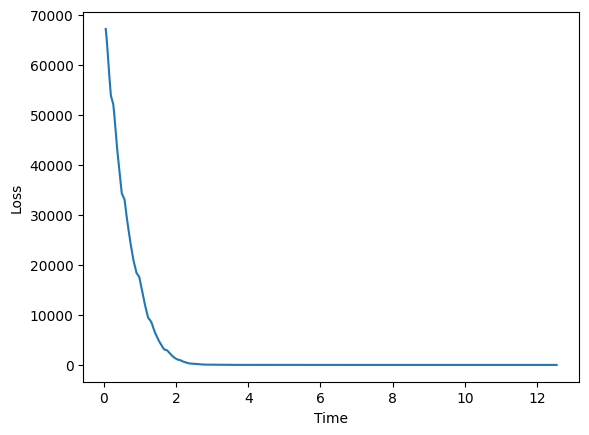

In [112]:
plt.plot(times, losses)
plt.xlabel('Time')
plt.ylabel('Loss')
plt.show()

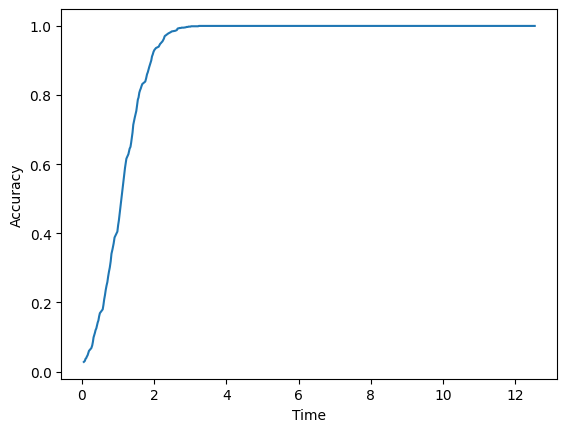

In [113]:
plt.plot(times, accuracies)
plt.xlabel('Time')
plt.ylabel('Accuracy')
plt.show()

In [114]:
# BCGD with Randomized Block Selection

# Gradient on Randomized Block where block is a row of X


def gradient_bcgd(X, block):

    AX = A.dot(X)
    soft_max = np.exp(AX[:,block]) / np.exp(AX).sum(axis=-1)
    return A.T.dot(soft_max - Y_oh[:,block])


In [115]:
# Gradient Descent
max_iter = 500
learning_rate = 0.001

bcgd_r_losses = []
bcgd_r_times = []
bcgd_r_accuracies = []

start_time = time.time()

for i in trange(max_iter):
    for j in range(NUM_CLASSES):
        block = np.random.randint(0, NUM_CLASSES)
        X_BCGD_R[:, block] -= learning_rate * gradient_bcgd(X_BCGD_R, block)
    if i % 1 == 0:
        bcgd_r_losses.append(loss(X_BCGD_R))
        bcgd_r_times.append(time.time() - start_time)
        bcgd_r_accuracies.append((Y == np.argmax(A.dot(X_BCGD_R), axis=1)).mean())

100%|██████████| 500/500 [02:17<00:00,  3.62it/s]


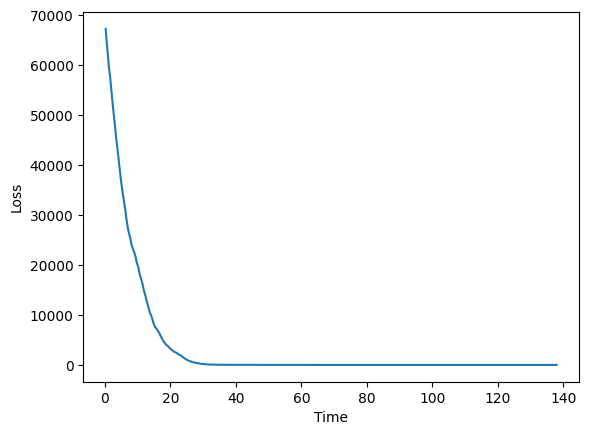

In [116]:
plt.plot(bcgd_r_times, bcgd_r_losses)
plt.xlabel('Time')
plt.ylabel('Loss')
plt.show()

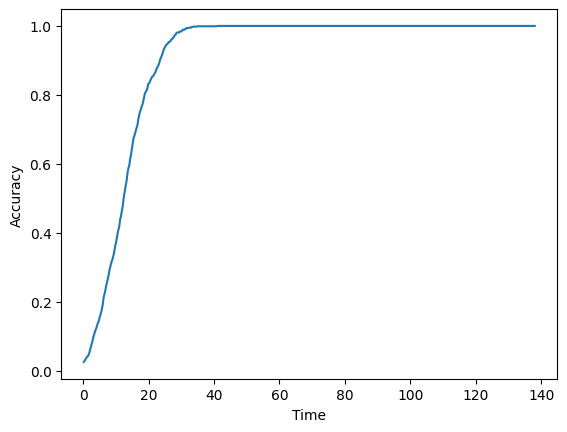

In [117]:
plt.plot(bcgd_r_times, bcgd_r_accuracies)
plt.xlabel('Time')
plt.ylabel('Accuracy')
plt.show()

In [118]:
def new_grad_residual(weights, gradient):
    AX = A.dot(weights)
    old_soft_max = np.exp(AX) / np.exp(AX).sum(axis=-1, keepdims=True)
    ws = weights - gradient
    AX = A.dot(ws)
    new_soft_max = np.exp(AX) / np.exp(AX).sum(axis=-1, keepdims=True)
    return A.T.dot(old_soft_max - new_soft_max)

In [126]:
# BCGD with GS Block Selection

# Gradient Descent
max_iter = 500
learning_rate = 0.001

bcgd_gs_losses = []
bcgd_gs_times = []
bcgd_gs_accuracies = []

grad = gradient(X_BCGD_GS)
start_time = time.time()

for i in trange(max_iter):
    for j in range(NUM_CLASSES):
        block = np.argmax(np.linalg.norm(grad))
        block_grad = grad[:,block]
        sparse_grad = np.zeros_like(grad)
        sparse_grad[:,block] = block_grad * learning_rate 
        new_grad_temp = new_grad_residual(X_BCGD_GS, sparse_grad) + grad
        X_BCGD_GS[:,block] -= learning_rate * block_grad
        grad = new_grad_temp
        
    if i % 1 == 0:
        bcgd_gs_losses.append(loss(X_BCGD_GS))
        bcgd_gs_times.append(time.time() - start_time)
        bcgd_gs_accuracies.append((Y == np.argmax(A.dot(X_BCGD_GS), axis=1)).mean())


  0%|          | 0/500 [00:00<?, ?it/s]

  1%|          | 4/500 [00:03<06:34,  1.26it/s]/var/folders/6s/cxj5rgw54dsbpmz890jbgcx40000gp/T/ipykernel_39331/634884505.py:6: RuntimeWarning: overflow encountered in exp
  new_soft_max = np.exp(AX) / np.exp(AX).sum(axis=-1, keepdims=True)
/var/folders/6s/cxj5rgw54dsbpmz890jbgcx40000gp/T/ipykernel_39331/634884505.py:6: RuntimeWarning: invalid value encountered in divide
  new_soft_max = np.exp(AX) / np.exp(AX).sum(axis=-1, keepdims=True)
/var/folders/6s/cxj5rgw54dsbpmz890jbgcx40000gp/T/ipykernel_39331/634884505.py:3: RuntimeWarning: overflow encountered in exp
  old_soft_max = np.exp(AX) / np.exp(AX).sum(axis=-1, keepdims=True)
/var/folders/6s/cxj5rgw54dsbpmz890jbgcx40000gp/T/ipykernel_39331/634884505.py:3: RuntimeWarning: invalid value encountered in divide
  old_soft_max = np.exp(AX) / np.exp(AX).sum(axis=-1, keepdims=True)
  1%|▏         | 7/500 [00:05<06:43,  1.22it/s]


KeyboardInterrupt: 

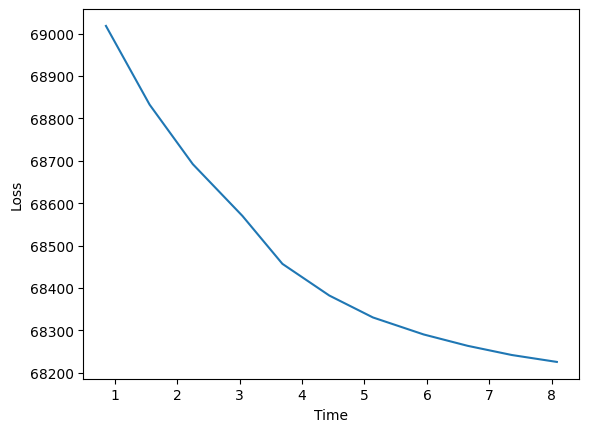

In [125]:
plt.plot(bcgd_gs_times, bcgd_gs_losses)
plt.xlabel('Time')
plt.ylabel('Loss')
plt.show()